In [1]:
import pandas as pd
from tqdm import tqdm
from helpers import stats as bf, file as fh, classification as pf
pd.set_option('mode.chained_assignment', None)

Setup Complete


In [10]:
start_season = 2012

random_state = 0

n_last_games = 10
n_last_specific_games = 5
betting_starts_after_n_games = 0

selected_models = ["logistic_regression", "random_forest_750"]
preprocess = True
min_odds = 1.8
bankroll = 900
strategy = "default"
default_value = 1
default_bankroll_pct = 0.05

plot_threshold = 0

features = [
    "home_odds", "away_odds",
    "home_pts", "home_pts_con",
    "home_fg_pct", "home_fg3_pct", 
    "home_ft_pct",
    "home_reb",
    "home_tov",
    "home_season_pct", "home_per", "home_elo", 
    "home_matchup_pct", "home_streak",
    "home_ha_pct",
    "home_last_games_pct", "home_ha_last_games_pct",
    "home_off_rtg", "home_def_rtg",
    # "home_is_b2b",
    "away_pts", "away_pts_con",
    "away_fg_pct", "away_fg3_pct",
    "away_ft_pct",
    "away_reb",
    "away_tov", 
    "away_season_pct", "away_per", "away_elo",
    "away_matchup_pct", "away_streak",
    "away_ha_pct",
    "away_last_games_pct", "away_ha_last_games_pct",
    "away_off_rtg", "away_def_rtg",
    # "away_is_b2b",
]

In [3]:
season_games, season_games_players, teams, teams_elo = bf.initialize_matches(start_season)

display(season_games[["date", "home_team", "away_team", "home_elo", "away_elo"]])

Generating teams ELOs...


100%|██████████| 15740/15740 [00:02<00:00, 6575.85it/s]


Successfully generated teams ELOs.


,date,home_team,away_team,home_elo,away_elo
0,2012-10-30,Cleveland Cavaliers,Washington Wizards,1500.00,1500.00
1,2012-10-30,Miami Heat,Boston Celtics,1500.00,1500.00
2,2012-10-30,Los Angeles Lakers,Dallas Mavericks,1500.00,1500.00
3,2012-10-31,Toronto Raptors,Indiana Pacers,1500.00,1500.00
4,2012-10-31,Philadelphia 76ers,Denver Nuggets,1500.00,1500.00
...,...,...,...,...,...
15735,2024-12-01,Brooklyn Nets,Orlando Magic,1430.78,1579.76
15736,2024-12-01,Memphis Grizzlies,Indiana Pacers,1498.28,1479.42
15737,2024-12-01,Cleveland Cavaliers,Boston Celtics,1591.66,1770.46
15738,2024-12-01,New York Knicks,New Orleans Pelicans,1581.08,1386.15


In [4]:
print("Creating CSV file of all games")

teams_per = dict()

matches_organized = []
matches_organized_playoffs = []
season = ""
stats_df_exists = False

stats_df = fh.load_df_from_file("../dist/data", f"{start_season}")
if stats_df is not None and str(stats_df.iloc[-1]['date']) == str(season_games.iloc[-1]['date'].date()):
    stats_df['date'] = pd.to_datetime(stats_df['date'])
    stats_df_exists = True
    print("Stats DF exist", stats_df_exists)
else:
    for i, g in tqdm(season_games.iterrows(), total=len(season_games)):
        season = g["season"]

        is_playoffs = int(g["is_playoff"])

        team_a_id = g["home_id"]
        team_b_id = g["away_id"]

        team_a_abbv = teams.loc[teams["id"] == team_a_id].iloc[0]["abbreviation"]
        team_b_abbv = teams.loc[teams["id"] == team_b_id].iloc[0]["abbreviation"]

        winner = g["winner"]

        # Update ELO after stats computed
        team_a_pts = g["home_pts"]
        team_b_pts = g["away_pts"]

        team_a_odds, team_b_odds = g["home_odds"], g["away_odds"]

        if not team_a_odds or not team_b_odds:
            continue

        stats_team_a = bf.get_game_data(
            season_games,
            season_games_players,
            teams_elo,
            g,
            team_a_id,
            team_b_id,
            teams_per,
            n_last_games,
            n_last_specific_games,
            "H",
        )
        if not stats_team_a:
            continue

        stats_team_b = bf.get_game_data(
            season_games,
            season_games_players,
            teams_elo,
            g,
            team_b_id,
            team_a_id,
            teams_per,
            n_last_games,
            n_last_specific_games,
            "A",
        )
        if not stats_team_b:
            continue

        match_info = bf.get_match_info(
            [season, g["date"], team_a_abbv, team_b_abbv, team_a_odds, team_b_odds],
            stats_team_a,
            stats_team_b,
            winner,
            team_a_pts,
            team_b_pts,
        )
        if is_playoffs:
            matches_organized_playoffs.append(match_info)
        else:
            matches_organized.append(match_info)

    print(
        "Total matches: {}\nTotal playoffs matches: {}".format(
            len(matches_organized), len(matches_organized_playoffs)
        )
    )

Creating CSV file of all games
Stats DF exist True


In [5]:
if not stats_df_exists:
    columns = [
        "season", "date", "home_team", "away_team", "home_odds", "away_odds",
        "home_pts", "home_pts_con", "home_fg_pct", "home_fg3_pct", "home_ft_pct", "home_reb", "home_tov", "home_season_pct",
        "home_per", "home_elo", "home_matchup_pct", "home_ha_pct", "home_streak", "home_last_games_pct", "home_ha_last_games_pct",
        "home_off_rtg", "home_def_rtg", "home_is_b2b",
        "away_pts", "away_pts_con", "away_fg_pct", "away_fg3_pct", "away_ft_pct", "away_reb", "away_tov", "away_season_pct",
        "away_per", "away_elo", "away_matchup_pct", "away_ha_pct", "away_streak", "away_last_games_pct", "away_ha_last_games_pct",
        "away_off_rtg", "away_def_rtg", "away_is_b2b",
        "result", "home_game_pts", "away_game_pts",
    ]

    stats_df = fh.parse_df_to_csv(
        matches_organized, columns, "../dist/data", f"{start_season}.csv"
    )

    fh.parse_df_to_csv(
        matches_organized_playoffs,
        columns,
        "../dist/data",
        f"{start_season}-playoffs.csv",
    )

display(stats_df)

,Unnamed: 0,season,date,home_team,away_team,home_odds,away_odds,home_pts,home_pts_con,home_fg_pct,...,away_ha_pct,away_streak,away_last_games_pct,away_ha_last_games_pct,away_off_rtg,away_def_rtg,away_is_b2b,result,home_game_pts,away_game_pts
0,0,2012,2012-11-17,PHX,MIA,3.20,1.36,99.3,105.0,0.4307,...,0.500000,1,0.7,0.6,111.655660,107.418542,False,A,88,97
1,1,2012,2012-11-18,DET,BOS,2.46,1.56,93.0,99.8,0.4378,...,0.600000,1,0.6,0.6,105.807366,104.982441,True,H,103,83
2,2,2012,2012-11-19,DAL,GSW,1.42,2.90,100.9,100.1,0.4627,...,0.500000,-1,0.5,0.4,100.099647,102.401857,True,A,101,105
3,3,2012,2012-11-19,UTA,HOU,1.33,3.37,96.2,97.8,0.4370,...,0.400000,-2,0.4,0.4,102.150776,102.700599,True,H,102,91
4,4,2012,2012-11-20,PHI,TOR,1.45,2.77,88.9,90.1,0.4109,...,0.200000,1,0.3,0.2,100.874199,104.481087,False,H,106,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12701,12701,2024,2024-12-01,BKN,ORL,3.15,1.38,112.4,117.3,0.4756,...,0.416667,5,0.9,0.8,111.795428,101.615310,False,A,92,100
12702,12702,2024,2024-12-01,MEM,IND,1.43,2.88,122.3,111.2,0.4869,...,0.200000,-1,0.4,0.0,111.009221,115.478129,False,H,136,121
12703,12703,2024,2024-12-01,CLE,BOS,1.84,2.00,120.2,113.9,0.4986,...,0.900000,7,0.9,1.0,120.313357,110.790872,False,H,115,111
12704,12704,2024,2024-12-01,NYK,NOP,1.13,6.16,120.8,114.3,0.5073,...,0.100000,-7,0.1,0.0,102.549093,115.736224,False,H,118,85


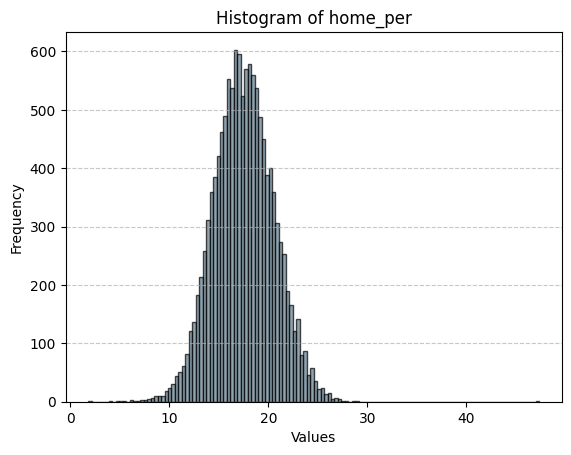

In [6]:
import matplotlib.pyplot as plt

column = 'home_per'

plt.hist(stats_df[column], bins='auto', alpha=0.7, color='#607c8e', edgecolor='black')

# Customize the plot
plt.title(f'Histogram of {column}')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [11]:
last_season = season_games.iloc[-1]["season"]

# Train and evaluate model
print("Training and evaluating models throughout the seasons...")
for season in tqdm(range(start_season + 1, last_season + 1)):
    season_games, trained_models = pf.simulate(
        stats_df,
        start_season,
        season,
        features,
        betting_starts_after_n_games,
        strategy,
        verbose=1,
        random_state=0,
        preprocess=preprocess,
        voting_classifier_models=selected_models
    )

Training and evaluating models throughout the seasons...


100%|██████████| 12/12 [16:50<00:00, 84.17s/it] 


In [12]:
feature_importances = trained_models['random_forest_default']['pipeline'].named_steps['model'].feature_importances_
feature_importance_mapping = dict(zip(features, feature_importances))

# Sort by importance
sorted_features = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)
for feature in sorted_features:
    print(feature)

('away_odds', 0.08584207730082108)
('home_odds', 0.07586075536921433)
('home_season_pct', 0.039378987096176654)
('home_streak', 0.033935340961122766)
('away_tov', 0.033370902753295906)
('away_season_pct', 0.033178407182811155)
('home_per', 0.03115340797149674)
('away_fg3_pct', 0.029618755686081393)
('home_fg3_pct', 0.029255588422818047)
('home_ft_pct', 0.02920350593397972)
('away_fg_pct', 0.029041241171272304)
('away_matchup_pct', 0.028964922464744452)
('home_ha_last_games_pct', 0.028424776651867264)
('away_pts_con', 0.027826792234411778)
('away_ha_last_games_pct', 0.02781477579870256)
('away_ft_pct', 0.02766404149750419)
('home_fg_pct', 0.02762923932011565)
('home_off_rtg', 0.027495150698049885)
('away_last_games_pct', 0.027117806741149865)
('home_tov', 0.026347754862307893)
('home_reb', 0.026170717743872883)
('away_reb', 0.025852575435785622)
('home_pts', 0.02564081877656044)
('home_def_rtg', 0.025351493809210403)
('home_pts_con', 0.024634022365483826)
('away_pts', 0.0243396789991002

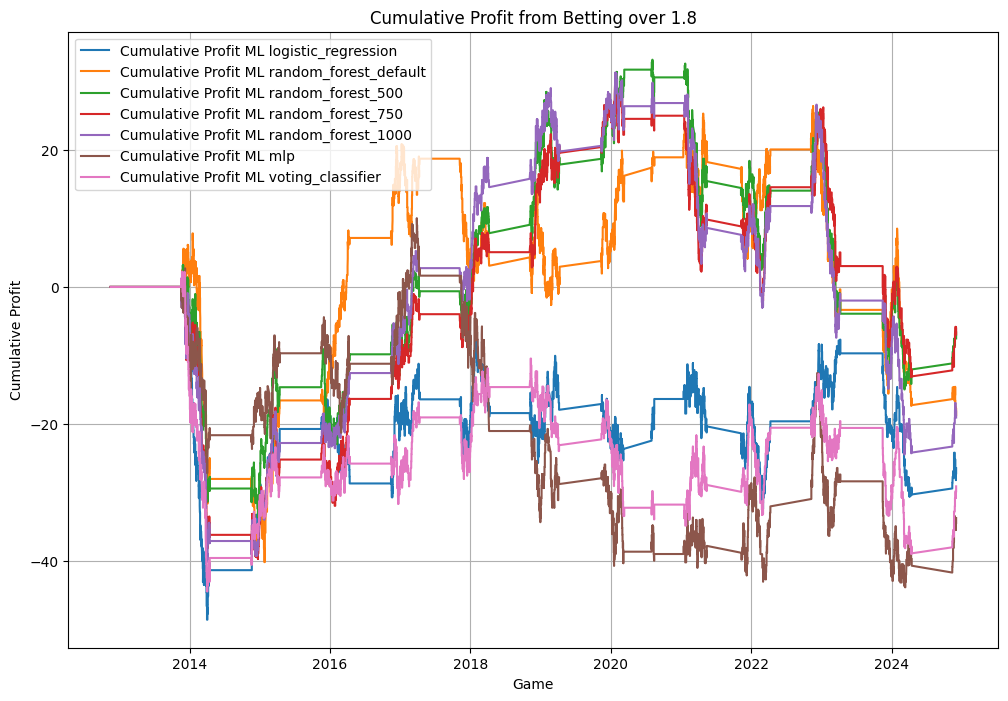

Home method (-204.53/4777): -0.0428
ML method with naive_bayes          --> (-132.59/2523): -0.0526
ML method with knn                  --> (-213.71/3926): -0.0544
ML method with logistic_regression  --> (  -26.5/1625): -0.0163
ML method with svm                  --> ( -94.38/2226): -0.0424
ML method with sgd                  --> (  -52.5/2969): -0.0177
ML method with random_forest_default --> ( -18.72/1898): -0.0099
ML method with random_forest_500    --> (  -7.52/1616): -0.0047
ML method with random_forest_750    --> (  -6.95/1592): -0.0044
ML method with random_forest_1000   --> ( -19.08/1572): -0.0121
ML method with gradient_boosting    --> ( -82.11/1665): -0.0493
ML method with ada_boost            --> ( -62.93/2121): -0.0297
ML method with mlp                  --> ( -33.76/1696): -0.0199
ML method with voting_classifier    --> ( -29.13/1446): -0.0201

Profit for random_forest_750: $-6.95
Accuracy for random_forest_750: 0.67
Classification Report for random_forest_750:
           

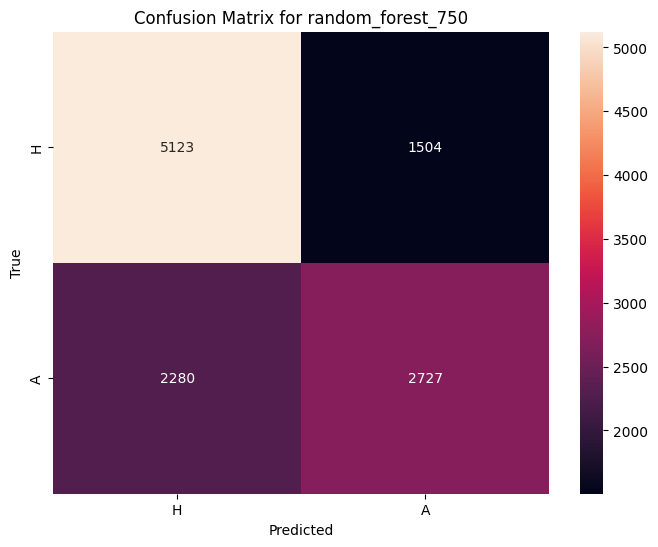

In [16]:
best_model_name = pf.get_simulation_results(season_games, start_season, 1.8, -50, random_state, bankroll, strategy, default_value, default_bankroll_pct)

#### 